* Play a little with KG embedding learning from semmed kg. - For link prediction without predicates. i.e naive graph link prediction
* Note: `Subject : Predicate -> Object`
    
  * PyKeen , DL-KGE...
  * Could use StellarGraph (keras friendly but needs old python version)? https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html ,
  * Ampligraph (Also tensorflow friendly) - https://docs.ampligraph.org/en/latest/examples.html
* https://pykeen.github.io/2020/08/07/benchmarking.html
    * rotatE, TuckER, TransE - do well
 
Relevant other paper did Trans-E on semmed : *"Evaluating Explanations from AI Algorithms for Clinical Decision-Making: A Social Science-based Approach"*


* pyKeen + curie biomed text represntations from entities to text (e.g. for transformer text rep) ; https://pykeen.readthedocs.io/en/stable/api/pykeen.nn.representation.BiomedicalCURIERepresentation.html#pykeen.nn.representation.BiomedicalCURIERepresentation

* * Load Pretrained models/representation, e.g. cui2vec : https://github.com/pykeen/pykeen/issues/637
  *  load init - https://pykeen.readthedocs.io/en/v1.8.1/reference/nn/init.html

In [1]:
MIN_EVIDENCE = 2#1#3#5 # filter counts/num of cases /pmids it appeared in - proxy to reduce noise
# MIN_ENT_FREQ = 150#250#80#140#210 # keep only cases with this many occurrences

# MIN_EVIDENCE = 1
MIN_ENT_FREQ = 80#250#80#140#210 # keep only cases with this many occurrences

REMOVE_NEG_PREDICATES = True # remove predicates containnig "neg" as I don't know if we want them for now

# RETRAIN_KG_MODEL = False#True#False
RETRAIN_KG_MODEL = True

SAVE_MODEL = True#False

PipeName = "min1_80"

In [2]:
# !export PYTORCH_ENABLE_MPS_FALLBACK=1

In [3]:
import pandas as pd
import numpy as np
## scispacy, medspacy, medcat, quickumls, semrep...
# import spacy

In [4]:
from pykeen.pipeline import pipeline
from pykeen.models import TransE
from pykeen.triples import TriplesFactory
# from pykeen.models.predict import get_tail_prediction_df
# https://pykeen.readthedocs.io/en/v1.10.2/api/pykeen.predict.predict_target.html#pykeen.predict.predict_target
from pykeen.predict import predict_target

# # https://pykeen.readthedocs.io/en/latest/tutorial/inductive_lp.html#label-based-transformer-representation
# ### "This is work in progress and not yet available." # pykeen.nn.representation import LabelBasedTransformerRepresentation

## https://pykeen.readthedocs.io/en/latest/api/pykeen.nn.init.LabelBasedInitializer.html
## Initialize entity representations as Transformer encodings of their labels. 
from pykeen.nn.init import LabelBasedInitializer
from pykeen.models import ERMLPE, ERModel
from pykeen.pipeline import pipeline
from pykeen.datasets import get_dataset
from pykeen.nn import TextRepresentation
from pykeen.datasets import get_dataset
from pykeen.models import ERModel, RotatE, TransR
from pykeen.nn.init import LabelBasedInitializer
from pykeen.pipeline import pipeline
import torch
import gc
from pykeen.evaluation import RankBasedEvaluator, SampledRankBasedEvaluator

from pykeen.nn.init import PretrainedInitializer, RandomWalkPositionalEncodingInitializer, LabelBasedInitializer
## https://pykeen.readthedocs.io/en/v1.10.2/api/pykeen.nn.init.LabelBasedInitializer.html#pykeen.nn.init.LabelBasedInitializer

torch.cuda.empty_cache()
gc.collect()

6

In [5]:
# ## load saved chkpoint from pykeen dir
# ## https://pykeen.readthedocs.io/en/stable/tutorial/checkpoints.html
# import torch
# from pykeen.constants import PYKEEN_CHECKPOINTS
# from pykeen.pipeline import pipeline
# from pykeen.triples import TriplesFactory
# # checkpoint = torch.load(PYKEEN_CHECKPOINTS.joinpath('my_checkpoint.pt'))

# # ## more styeps

# # from pykeen.models import TransE
# # my_model = TransE(triples_factory=train)
# # my_model.load_state_dict(checkpoint['model_state_dict'])

#### candidate_features names_list = names of features selected in previous stages
* candidate_feature_names_list - text names - free text. Made manually
* Other: CUIs list (CUIs linked to feature names + target cuis)

In [6]:
candidate_feature_names_list = pd.read_csv("../cand_feature_names.csv",header=None,quoting=1)[0]
len(candidate_feature_names_list)

150

* NOTE: Not all the CUIs are found i nthe KG, even without any frequency filtering

In [7]:
df_candidates = pd.read_csv("../candidate_novel_cuis.csv").drop_duplicates()
display(df_candidates)
candidate_feature_cuis_list = df_candidates["cui"].drop_duplicates()
print(len(candidate_feature_cuis_list))

,feature_name,cui,cui_nomenclature,KG_Hits,feature_level_min_kg_hits,feature_level_max_kg_hits
0,HDL cholesterol Blood biochemistry,C0023822,High Density Lipoprotein Cholesterol,2,0,2
1,HDL cholesterol Blood biochemistry,C0428472,Serum HDL cholesterol measurement,0,0,2
2,HDL cholesterol Blood biochemistry,C2357172,Cholesterol.in HDL,0,0,2
3,HDL cholesterol Blood biochemistry,C0018667,"Cholesterol, HDL2",0,0,2
4,HDL cholesterol Blood biochemistry,C0018668,"Cholesterol, HDL3",0,0,2
...,...,...,...,...,...,...
732,Cancer of oropharynx,C0006826,Malignant Neoplasms,5,0,5
733,Cancer of oropharynx,C0998265,Cancer Genus,0,0,5
734,Cancer of oropharynx,C1306459,Primary malignant neoplasm,0,0,5
735,Cancer of oropharynx,C1547140,Specialty Type - cancer,0,0,5


411


#### Load KG and filter rare entities/relations
* `first_year_pair` - first time pair of subject, object occurred.
* `first_year_triple`

In [8]:
def check_kg_cui_overlap(df_kg,candidate_feature_cuis_list,return_all_ents = False):
    ## check coverage of candidate CUIs in raw data  pre frequency filtering - should be 100% !
    all_entities_list = set(df_kg["SUBJECT_CUI"].unique()).union(df_kg["OBJECT_CUI"].unique())
    print(len(all_entities_list),"# Total entities in raw data")
    num_candidate_cuis_covered_raw = len(set(candidate_feature_cuis_list).intersection(all_entities_list))
    ## warning: only ~80% covered
    print("% Candidate novel CUIs coverage possible data",round(100*num_candidate_cuis_covered_raw/len(candidate_feature_cuis_list),2))
    if return_all_ents:
        return all_entities_list  

In [9]:
%%time
df_kg = pd.read_parquet("predications.parquet",columns=['SUBJECT_CUI', 'SUBJECT_NAME',  'PREDICATE', 'OBJECT_CUI', 'OBJECT_NAME',
                                                        "first_year_pair","counts"]) 
print(df_kg.shape[0])

## check coverage of candidate CUIs in raw data pre frequency filtering - We see it's not 100% !
all_entities_list = check_kg_cui_overlap(df_kg,candidate_feature_cuis_list,return_all_ents=True)

# CUI - name map for all cases in dataset
df_map = pd.concat([df_kg[['SUBJECT_CUI', 'SUBJECT_NAME']].rename(columns={'SUBJECT_NAME':"name",'SUBJECT_CUI':"CUI"}),
          df_kg[['OBJECT_CUI', 'OBJECT_NAME']].rename(columns={'OBJECT_NAME':"name",'OBJECT_CUI':"CUI"})]).drop_duplicates() 
print(df_map.shape[0],"df_map")

if REMOVE_NEG_PREDICATES:
    df_kg = df_kg.loc[~df_kg["PREDICATE"].str.contains("neg_",case=False)]
    print(df_kg.shape[0],"without neg predicates") # 26M

#########
df_kg = df_kg.loc[df_kg["counts"]>=MIN_EVIDENCE].copy()
print("After filtering min count",df_kg.shape[0])
df_kg = df_kg.loc[(df_kg.groupby("SUBJECT_CUI").transform("size")>MIN_ENT_FREQ) & (df_kg.groupby("OBJECT_CUI").transform("size")>MIN_ENT_FREQ)\
 & (df_kg.groupby("PREDICATE").transform("size")>MIN_ENT_FREQ)]
print("After filtering entity count 1",df_kg.shape[0])
# for c in df_kg.select_dtypes("category").columns:
# # remove unobserved categories, in new filtered data
#     df_kg[c] = df_kg[c].cat.remove_unused_categories()
df_kg = df_kg.loc[(df_kg.groupby("SUBJECT_CUI").transform("size")>MIN_ENT_FREQ) & (df_kg.groupby("OBJECT_CUI").transform("size")>MIN_ENT_FREQ)\
& (df_kg.groupby("PREDICATE").transform("size")>MIN_ENT_FREQ)]
df_kg = df_kg.loc[(df_kg.groupby("SUBJECT_CUI").transform("size")>MIN_ENT_FREQ) & (df_kg.groupby("OBJECT_CUI").transform("size")>MIN_ENT_FREQ)\
& (df_kg.groupby("PREDICATE").transform("size")>MIN_ENT_FREQ)]
df_kg = df_kg.loc[(df_kg.groupby("SUBJECT_CUI").transform("size")>MIN_ENT_FREQ) & (df_kg.groupby("OBJECT_CUI").transform("size")>MIN_ENT_FREQ)\
& (df_kg.groupby("PREDICATE").transform("size")>MIN_ENT_FREQ)].copy().reset_index(drop=True)
print("After filtering entity count 2",df_kg.shape[0])

# for c in df_kg.select_dtypes("category").columns:
# # remove unobserved categories, in new filtered data
#     df_kg[c] = df_kg[c].cat.remove_unused_categories()
print(df_kg.shape[0]) # 4M
print(df_kg.nunique())
df_kg.drop(columns=["counts"],errors="ignore",inplace=True)

#########
## following now redundnat, done in advance!
## drop ||| gene objecgts (that require exploding 
splitter_mask = (df_kg["SUBJECT_CUI"].str.contains(r"|",case=False,regex=False)) | (df_kg["OBJECT_CUI"].str.contains(r"|",case=False,regex=False))
for col in df_kg.select_dtypes(include=['category']).columns:
  df_kg[col] = df_kg[col].astype('str')
    
df_kg.loc[splitter_mask,"SUBJECT_NAME"] = df_kg.loc[splitter_mask]["SUBJECT_NAME"].str.split(r"|",regex=False,expand=True)[0]
df_kg.loc[splitter_mask,"OBJECT_NAME"] = df_kg.loc[splitter_mask]["OBJECT_NAME"].str.split(r"|",regex=False,expand=True)[0]

df_kg.loc[splitter_mask,"SUBJECT_CUI"] = df_kg.loc[splitter_mask]["SUBJECT_CUI"].str.split(r"|",regex=False,expand=True)[0]
df_kg.loc[splitter_mask,"OBJECT_CUI"] = df_kg.loc[splitter_mask]["OBJECT_CUI"].str.split(r"|",regex=False,expand=True)[0]

# shouldn't matter much to do this again , but why not 
df_kg = df_kg.loc[(df_kg.groupby("SUBJECT_CUI").transform("size")>MIN_ENT_FREQ) & (df_kg.groupby("OBJECT_CUI").transform("size")>MIN_ENT_FREQ)\
& (df_kg.groupby("PREDICATE").transform("size")>MIN_ENT_FREQ)]


check_kg_cui_overlap(df_kg,candidate_feature_cuis_list)

for col in df_kg.select_dtypes(include=['O']).columns:
  df_kg[col] = df_kg[col].astype('category')
print(df_kg.shape[0],"Without |'s") # 26M

df_kg.reset_index(drop=True)

df_kg

27350322
393509 # Total entities in raw data
% Candidate novel CUIs coverage possible data 80.05
416050 df_map
25677725 without neg predicates
After filtering min count 8097789


<timed exec>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


After filtering entity count 1 5371466


<timed exec>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence th

After filtering entity count 2 5158096
5158096
SUBJECT_CUI        13383
SUBJECT_NAME       16295
PREDICATE             31
OBJECT_CUI         11746
OBJECT_NAME        14208
first_year_pair      244
counts              3880
dtype: int64
15780 # Total entities in raw data
% Candidate novel CUIs coverage possible data 49.39
5157219 Without |'s
CPU times: user 31.4 s, sys: 13.6 s, total: 45 s
Wall time: 38.7 s


,SUBJECT_CUI,SUBJECT_NAME,PREDICATE,OBJECT_CUI,OBJECT_NAME,first_year_pair
0,C0087111,Therapeutic procedure,TREATS,C0030705,Patients,1902
2,C0012634,Disease,PROCESS_OF,C0030705,Patients,1902
3,C0543467,Operative Surgical Procedures,TREATS,C0030705,Patients,1821
4,C1457887,Symptoms,PROCESS_OF,C0030705,Patients,1898
5,C0006826,Malignant Neoplasms,PROCESS_OF,C0030705,Patients,1829
...,...,...,...,...,...,...
5158091,10002,NR2E3,AFFECTS,C0007590,Cell division,1993
5158092,10002,NR2E3,ADMINISTERED_TO,C0872076,Pluripotent Stem Cells,2008
5158093,10002,NR2E3,ADMINISTERED_TO,C0872076,Pluripotent Stem Cells,2008
5158094,10002,NR2E3,ADMINISTERED_TO,C0227525,Hepatocyte,2014


In [10]:
#### CUIs that aren't found at all in our KG: 
# x1.difference(x2) and x1 - x2 return the set of all elements that are in x1 but not in x2:
unique_candidates_list = set(candidate_feature_cuis_list).difference(all_entities_list)
df_candidates.loc[df_candidates["cui"].isin(unique_candidates_list)].select_dtypes("O").drop_duplicates()

,feature_name,cui,cui_nomenclature
2,HDL cholesterol Blood biochemistry,C2357172,Cholesterol.in HDL
11,SHBG,C0312446,Somatotropin binding globulin
12,SHBG,C1366439,SHBG gene
15,Diaphragmatic hernia,C1840643,DIAPHRAGMATIC HERNIA 1
16,Diaphragmatic hernia,C1857284,Diaphragmatic Hernia 2
...,...,...,...
722,Disturbance of skin sensation,C2699787,Disturbance
724,Iatrogenic hypotension,C0439669,iatrogenic
733,Cancer of oropharynx,C0998265,Cancer Genus
735,Cancer of oropharynx,C1547140,Specialty Type - cancer


In [11]:
df_kg.PREDICATE.value_counts()

PREDICATE
LOCATION_OF         755010
AFFECTS             547687
TREATS              485070
COEXISTS_WITH       386902
INTERACTS_WITH      371133
PROCESS_OF          321431
PART_OF             294990
ASSOCIATED_WITH     257310
CAUSES              247806
STIMULATES          209820
INHIBITS            157525
AUGMENTS            139744
DISRUPTS            117773
USES                111862
PREDISPOSES          97266
PRODUCES             86740
compared_with        86434
DIAGNOSES            82509
ADMINISTERED_TO      81393
PREVENTS             69047
ISA                  56423
MEASURES             53522
PRECEDES             40427
METHOD_OF            30915
higher_than          20580
OCCURS_IN            19794
MANIFESTATION_OF      9164
CONVERTS_TO           7659
COMPLICATES           6376
lower_than            2758
same_as               2149
Name: count, dtype: int64

In [12]:
# ## "novelty" look?
# ## partial mini list. Not exhaustive
# subsetPredicates = {"AFFECTS","TREATS","PREVENTS","INHIBITS","DISRUPTS","INTERACTS_WITH","PREDISPOSES","PREVENTS",
#                     "CAUSES","STIMULATES","AUGMENTS","PREDISPOSES","PRECEDES",
#                     "NEG_TREATS","NEG_AFFECTS","NEG_PROCESS_OF","NEG_ISA","NEG_ASSOCIATED_WITH","NEG_CAUSES"} # made into set instead of list


# if REMOVE_NEG_PREDICATES:
#     subsetPredicates = [x for x in subsetPredicates if "NEG" not in x]

# # df_kg.loc[df_kg["SUBJECT_NOVELTY"] | df_kg["OBJECT_NOVELTY"]].head(10)
# df_kg.loc[(df_kg["OBJECT_NOVELTY"]) & (df_kg["PREDICATE"].isin(subsetPredicates))].head(4)

# # subsetPredicates = dict(subsetPredicates)

### Use only 1 predicate - link exists or not
* Technically, directional predicate in terms of how data was

In [13]:
df_kg["PREDICATE"] = "link"
print(df_kg.shape[0])
df_kg = df_kg.sort_values(["first_year_pair"],ascending=True).drop_duplicates() ## maybe need to sort by dates  efore drop duplicates? 

print(df_kg.shape[0])

5157219
3880242


In [14]:
df_kg

,SUBJECT_CUI,SUBJECT_NAME,PREDICATE,OBJECT_CUI,OBJECT_NAME,first_year_pair
892534,C0038999,Swelling,link,C0007457,Caucasoid Race,1781
465312,C0037949,Vertebral column,link,C0333519,Caries,1781
892535,C0038999,Swelling,link,C0007457,Caucasian,1781
3245483,C0005682,Bladder,link,C0016832,fungus,1782
159783,C0005682,Bladder,link,C0041582,Ulcer,1782
...,...,...,...,...,...,...
5088188,C0001563,"Administration, Oral",link,C4324621,Opioid Use Disorder,2024
3337846,C3826426,Dynamics,link,C0033975,Psychotic Disorders,2024
5099653,C0001128,Acids,link,C4505073,Metal-Organic Frameworks,2024
3331076,C4699572,High probability,link,C0242665,wife,2024


### Temporal train/test/val splits
* X years, and keep if relation only appeared in later years?
* ALT: Keep if relation appears in alter year (even if appeared before)?

In [15]:
# df.query("counts>2 & first_year_pair>1948")["first_year_pair"].hist()
df_kg.query("first_year_pair>1968")["first_year_pair"].describe().round()

count    3634395.0
mean        1998.0
std           14.0
min         1969.0
25%         1987.0
50%         1998.0
75%         2009.0
max         2024.0
Name: first_year_pair, dtype: float64

In [16]:
df_train = df_kg.query("first_year_pair<=2020")
train_entities_list = set(df_train["SUBJECT_CUI"].unique()).union(df_train["OBJECT_CUI"].unique())
print(len(train_entities_list),"# unique entities in train")
print(len(train_entities_list)/df_train.shape[0],"# len(train_entities_list)/df_train.shape[0]")
print("Train",df_train.shape[0])
df_test = df_kg.query("first_year_pair>2020")
print("df_test rows pre filt",df_test.shape[0])
df_test = df_test.loc[df_test["SUBJECT_CUI"].isin(train_entities_list) & df_test["OBJECT_CUI"].isin(train_entities_list)]
print("df_test rows post filt",df_test.shape[0])

15775 # unique entities in train
0.004206474851413442 # len(train_entities_list)/df_train.shape[0]
Train 3750171
df_test rows pre filt 130071
df_test rows post filt 129626


In [17]:
### pandas - do anti join
### https://stackoverflow.com/questions/38516664/anti-join-pandas
# df_test.drop(df_test.merge(df_train,how="inner",on=["SUBJECT_CUI","OBJECT_CUI","PREDICATE"]).index)

# pd.concat([df_test,
#           df_train.loc[~df_train["SUBJECT_CUI", "OBJECT_CUI",
#           "PREDICATE"].isin(df_test["SUBJECT_CUI","OBJECT_CUI","PREDICATE"])]], ignore_index=True)

def anti_join(tableA,tableB,on): ## check if works?

   #if joining on index, make it into a column
   if tableB.index.name is not None:
       dummy = tableB.reset_index()[on]
   else:
       dummy = tableB[on]

   #create a dummy columns of 1s
   if isinstance(dummy, pd.Series):
       dummy = dummy.to_frame()

   dummy.loc[:,'dummy_col'] = 1

   #preserve the index of tableA if it has one
   if tableA.index.name is not None:
       idx_name = tableA.index.name
       tableA = tableA.reset_index(drop = False)
   else:
       idx_name = None

   #do a left-join
   merged = tableA.merge(dummy,on=on,how='left')

   #keep only the non-matches
   output = merged.loc[merged.dummy_col.isna(),tableA.columns.tolist()]

   #reset the index (if applicable)
   if idx_name is not None:
       output = output.set_index(idx_name)
       
   output.drop_duplicates(subset=on,inplace=True) ## DAN added - otherwise duplicates? 
   return(output)
print(df_test.shape[0])
print(df_test[["SUBJECT_CUI","OBJECT_CUI"]].nunique())
df_test = anti_join(df_test,df_train,["SUBJECT_CUI","OBJECT_CUI"]) # ,"PREDICATE"
print(df_test.shape[0])
print(df_test[["SUBJECT_CUI","OBJECT_CUI"]].nunique())

129626
SUBJECT_CUI    9917
OBJECT_CUI     8752
dtype: int64


/tmp/ipykernel_3309/2293179532.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy.loc[:,'dummy_col'] = 1


128136
SUBJECT_CUI    9912
OBJECT_CUI     8745
dtype: int64


In [18]:
test_entities_list = set(df_test["SUBJECT_CUI"].unique()).union(df_test["OBJECT_CUI"].unique())
print(len(test_entities_list), "# test entities")
print(df_test.shape[0]/len(test_entities_list),"# len(train_entities_list)/df_train.shape[0]")

12421 # test entities
10.316077610498349 # len(train_entities_list)/df_train.shape[0]


#### What's the maximum novel candidates possible coverage , after we've filtered the data by min entity freq?

In [19]:
num_candidate_cuis_covered = len ([c for c in candidate_feature_cuis_list if c in train_entities_list.union(test_entities_list)])
# set(candidate_feature_cuis_list.values)
print("# Candidate CUIs possible in current train data",num_candidate_cuis_covered)
print("% Candidate novel CUIs coverage possible in current train data",round(100*num_candidate_cuis_covered/len(candidate_feature_cuis_list),2))

# Candidate CUIs possible in current train data 203
% Candidate novel CUIs coverage possible in current train data 49.39


* Training - assumption of LCWA
* https://pykeen.readthedocs.io/en/stable/reference/training.html#local-closed-world-assumption
* hetionet example inc loading ,eval: https://github.com/tomasonjo/blogs/blob/master/pykeen/Hetionet%20-%20RotatE.ipynb

* mps -> memory issues/crashes?

* Another example pykeen : https://pykeen.readthedocs.io/en/stable/tutorial/first_steps.html
* RotatE seems good from lit, on hetionet
* pubmedKG for text/sentencetransformer embedding?
* GCN https://pykeen.readthedocs.io/en/stable/reference/nn/pyg_message_passing.html

In [20]:
%%time
from pykeen.nn import TextRepresentation
## https://pykeen.readthedocs.io/en/latest/tutorial/representations.html#text-based

# ### load new data example: https://towardsdatascience.com/knowledge-graph-completion-with-pykeen-and-neo4j-6bca734edf43
# # .astype("category")
# tf = TriplesFactory.from_labeled_triples(
#   df_kg.rename(columns={"SUBJECT_NAME":"source",
#                         "PREDICATE":"type",
#                         "OBJECT_NAME":"target"})[["source", "type", "target"]].values ,
# )

CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 6.68 μs


In [21]:
# training, testing, validation = tf.split([.96, .02, .02])
# # training, testing, validation = tf.split([.8, .1, .1])

## new splits
training = TriplesFactory.from_labeled_triples(
  df_train.rename(columns={"SUBJECT_CUI":"source",
                        "PREDICATE":"type",
                        "OBJECT_CUI":"target"})[["source", "type", "target"]].values ,
)

tf = training

tf_future = TriplesFactory.from_labeled_triples(
  df_test.rename(columns={"SUBJECT_CUI":"source",
                        "PREDICATE":"type",
                        "OBJECT_CUI":"target"})[["source", "type", "target"]].values ,
)

testing, validation = tf_future.split([0.8,0.2])

using automatically assigned random_state=1633695571


* Another text-kg example code inc triples:
    * https://gist.github.com/airysen/2b4f8b5dff8cc72b8951d4457228a7bd
Example of using LM embeddings in pykeen
```

from pykeen.training import SLCWATrainingLoop
from pykeen.datasets import get_dataset
from pykeen.nn.representation import TextRepresentation
from pykeen.models import ERModel

from pykeen.pipeline import pipeline

from torch.optim import Adam


dataset = get_dataset(dataset="nations")
entity_representations = TextRepresentation.from_triples_factory(
    triples_factory=dataset.training,
    encoder="transformer",
    encoder_kwargs=dict(pretrained_model_name_or_path="bert-base-multilingual-uncased", max_length=512)
)


model = ERModel(
    triples_factory=dataset.training,
    interaction="ermlpe",
    entity_representations=entity_representations,
    relation_representations_kwargs=dict(shape=entity_representations.shape),
    interaction_kwargs=dict(embedding_dim=entity_representations.shape[0], input_dropout=0.1, hidden_dim=256, hidden_dropout=0.2),
    entity_representations_kwargs=dict(max_length=512),
    random_seed=42,
    # relation_representations_kwargs=dict(embedding_dim=3, dropout=0.1),
)


```

In [22]:
import gc
torch.cuda.empty_cache()
gc.collect()

28

In [23]:
# %%time
# try: # load already trained model (not same as results!)
#     model = torch.load('./saved/trained_model.pkl') # try this ?  - loads model , not results...
#     model
# except:
#     try:
#         model = torch.load('./saved/trained_model.pkl',map_location=torch.device('cpu')) # try this ? 
#         model
#     except: print("No saved model loaded")

* example with pykeen, graphsage, sampledRankEval - https://medium.com/@sauravjoshi23/knowledge-graph-reasoning-from-node2vec-to-ultra-across-transductive-and-inductive-tasks-2a234aafbffc


https://pykeen.readthedocs.io/en/stable/tutorial/first_steps.html#using-learned-embeddings
* https://github.com/pykeen/pykeen/issues/1365
    * Get/save embeddings (e.f. Transe)
    * ```
      entity_embeddings = model.entity_representations[0]
      entity_embedding_tensor: torch.FloatTensor = entity_embeddings(indices=None)
      relation_embeddings: pykeen.nn.Embedding = model.relation_representations[0]
      ```
      

INFO:pykeen.training.training_loop:=> no checkpoint found at 'saved/min1_80.pt'. Creating a new file.


Training epochs on cuda:0:   0%|          | 0/60 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/25.6k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 242.44s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 1.0. Saved model weights to /home/ddofer/.data/pykeen/checkpoints/best-model-weights-6f45aed1-d358-4ccd-a3c2-5f01af49a568.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/25.6k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 47.31s seconds


Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/12929 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/25.6k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 44.80s seconds
INFO:pykeen.stoppers.early_stopping:Stopping early at epoch 30. The best result 1.0 occurred at epoch 10.
INFO:pykeen.stoppers.early_stopping:Re-loading weights from best epoch from /home/ddofer/.data/pykeen/checkpoints/best-model-weights-6f45aed1-d358-4ccd-a3c2-5f01af49a568.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Evaluating on cuda:0:   0%|          | 0.00/25.6k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 44.77s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=15775, num_relations=1, create_inverse_triples=False, num_triples=3309716) to file:///mnt/c/Users/ddofe/OneDrive%20-%20Medtronic%20PLC/Documents/research/InterestingFeats/SemMed/min1_80/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /mnt/c/Users/ddofe/OneDrive - Medtronic PLC/Documents/research/InterestingFeats/SemMed/min1_80


CPU times: user 18min 45s, sys: 1min 24s, total: 20min 9s
Wall time: 20min 54s


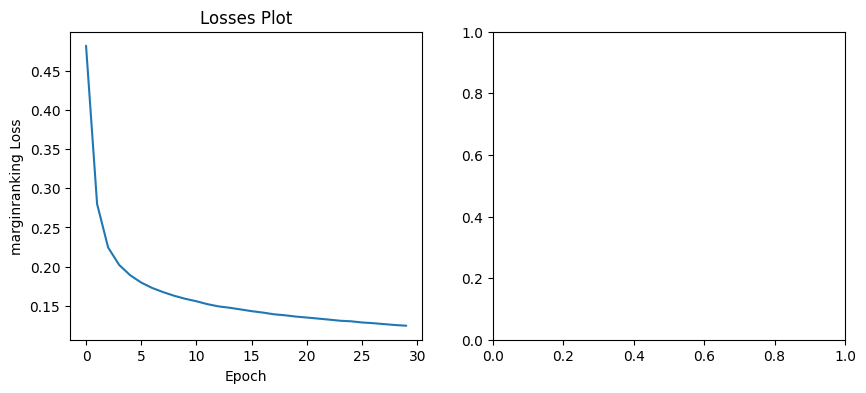

In [24]:
%%time
## https://pykeen.readthedocs.io/en/stable/api/pykeen.pipeline.pipeline.html#pykeen.pipeline.pipeline

if RETRAIN_KG_MODEL:
    
    results = pipeline(
        training=training,
        testing=testing,
        validation=validation,
        # model= "TransD" #"TransH"#"TuckER"#"TransD"#'Complex',#"TuckER",
        # model='DistMult' ## this seems to work, without crashing, on cpu
         # model="ermlpe"
        # model="ComplEx"
        model="RotatE"
        
        # model="TuckER"
        # model="convKB" ## - Should initialize entity and relation embeddings from TransE with this. # SLooooow to evaluate
        # model="RGCN" # https://pykeen.readthedocs.io/en/v1.10.2/api/pykeen.models.RGCN.html
        
        ,epochs=  60#15 #60#3#80
        # ,dimensions= 16#400#500#128
        ,dimensions= 400
        ,random_seed=42,
        # ,device='mps', ## apple silicon - crashes OOM ; but works with cpu? depends on size, embed size
        # device="cpu", # "cuda" # runs stably on cuda
         device="cuda",
        # evaluation_fallback = True,
        stopper='early', ## may crash? 
        # stopper = None,
        evaluator = SampledRankBasedEvaluator(
            num_negatives=5, evaluation_factory=tf_future,
                         additional_filter_triples=[training.mapped_triples] # add? 
            # testing.mapped_triples,
        # validation.mapped_triples
               ## testing 
        ) # speed up, but optimistic
        # entity_initializer=RandomWalkPositionalEncodingInitializer(#LabelBasedInitializer.from_triples_factory(
        # triples_factory=training, dim=200,
        # # encoder="transformer",
        # ),
        
        # model_kwargs=dict( , embedding_dim=256, num_layers=1)  # https://pykeen.readthedocs.io/en/v1.10.2/api/pykeen.models.RGCN.html  -reduce rgcn defaults
            
        # evaluation_relation_whitelist=subsetPredicates ## evaluate only on subset of relations
        ,evaluation_entity_whitelist=test_entities_list, # only eval on subset of entities
    
        # ## following relevant when not running with cuda (due to automatic_memory_optimization bugs):
        # training_loop_kwargs=dict(automatic_memory_optimization=False), # ,batch_size=1024
        # training_kwargs=dict(batch_size=32),
        # evaluator_kwargs=dict(automatic_memory_optimization=False,batch_size=8), # batch_size
        # # evaluation_kwargs=dict(automatic_memory_optimization=False,batch_size=8),
        # # result_tracker='csv', # added - not sure if needed?

        use_testing_data = False, ## Will make it use eval; not recommended default for the pykeen assumptions!
        training_kwargs=dict(
        # num_epochs=2000,
        # checkpoint_name='my_checkpoint.pt',
        checkpoint_directory='./saved/',
        checkpoint_name=f'{PipeName}.pt',
        # checkpoint_directory=f'./{PipeName}/',
            
        checkpoint_on_failure=True,
        ),
    )
    
    try:
        results.plot()
    except:()
    if SAVE_MODEL:
        # results.save_to_directory('./saved/')
        results.save_to_directory(f'./{PipeName}/')

    model=results.model
    
    results

# model = torch.load('./saved/trained_model.pkl')

In [25]:
# len(results.losses)
# results.training_loop()

### how to display results?


In [26]:
# %%time
# # Train your model (code is omitted for brevity)

# # Define evaluator
# ## SampledRankBasedEvaluator
# # 
# evaluator =RankBasedEvaluator(filtered=True)
# # evaluator = SampledRankBasedEvaluator(
# #     evaluation_factory=tf_future,
# #     # filtered=True,  # Note: this is True by default; we're just being explicit
# #     filtered=False,
# #      num_negatives=15,
# #         additional_filter_triples=[
# #         training.mapped_triples,
# #         validation.mapped_triples,
# #     ],
# # ) ## error - "SampledRankBasedEvaluator needs the true scores!"

# # Evaluate your model with not only testing triples,
# # but also filter on validation triples
# eval_results = evaluator.evaluate(
#     # model=results.model,
#     model = model,
#     # restrict_entities_to=test_entities_list, # only eval on subset of entities - fails ?
#     # pre_filtered_triples=False,
#         mapped_triples=testing.mapped_triples,
#     additional_filter_triples=[
#         training.mapped_triples,
#         validation.mapped_triples,
#     ],
# )


# df_rank_eval = eval_results.to_df()
# df_rank_eval = df_rank_eval.query("Rank_type == 'optimistic'")
# # df_rank_eval
# df_rank_eval.query("Side == 'both'") # vs head, tail

In [27]:
# results.save_to_directory('./saved/')

#### Transformer embeedder after this - I couldn't get it working great? 

In [28]:
# ## try new 
# entity_initializer = LabelBasedInitializer.from_triples_factory(
#     triples_factory=training,
#     for_entities=True,
#     encoder="transformer",
#      # model_kwargs=dict(device="mps") # doesn't work
# )

# ### https://pykeen.readthedocs.io/en/latest/tutorial/representations.html#text-based

In [29]:
# # entity_representations = TextRepresentation.from_dataset(
# #     dataset=tf,
# #     encoder="transformer",
# # )

# entity_representations = TextRepresentation.from_triples_factory(
#     triples_factory=tf,
#     encoder="transformer",
# )

In [30]:
# dataset = get_dataset(dataset="nations")
# entity_representations = TextRepresentation.from_dataset(
#     dataset=dataset,
#     encoder="transformer",
# )
# result = pipeline(
#     dataset=dataset,
#     model=ERModel,
#     model_kwargs=dict(
#         # interaction= "TransE",, # not using ermlpe -> error
#         interaction="ermlpe", # not using ermlpe -> error
        
#         interaction_kwargs=dict(
#             embedding_dim=entity_representations.shape[0],
#         ),
#         entity_representations=entity_representations,
#         relation_representations_kwargs=dict(
#             shape=entity_representations.shape,
#         ),
#     ),
#     training_kwargs=dict(
#         num_epochs=2,
#     ),
# )
# model = result.model
# result.plot()

In [31]:
# %%time
# from pykeen.models import ERModel
# ## memory crash on apple silicon in eval
# ## may have cpu memory leak - when running with more epochs. 

# rot_results = pipeline(
#     training=training,
#     testing=testing,
#     validation=validation,
#     model=ERModel, #"TransE",#"TransH", #"TransR",#"TransE",#"TransH", #'RotatE', # aten::complex.out - not supported on mps
#      # model= "QuatE",
#     # model="convKB", ## To be consistent with the paper, should initialize entity and relation embeddings from TransE.
#     # model="RotatE",
#     # model="TuckER",
#     # epochs=2#35,
#     epochs=2,
#     # dimensions= 512,
#     random_seed=42,
#     # device='mps', ## apple silicon - crashes OOM ; but works with cpu? depends on size, embed size
#     # device="cpu", # "cuda" # runs stably on cuda
#     evaluation_fallback = True,
#     stopper='early', ## may crash? 
#     # evaluation_relation_whitelist=subsetPredicates, ## evaluate only on subset of relations
    
#     # # ## try adding for Transformer embed
#     # model_kwargs=dict(entity_representations_kwargs=dict(
#     #         # triples_factory=dataset.training,
#     #         base_kwargs=dict(
#     #             # shape=embedding_dim,
#     #             initializer=entity_initializer,
#     #         ))),

#     model_kwargs=dict(
#         interaction="ermlpe",
#         # interaction="transe",
#         interaction_kwargs=dict(
#             embedding_dim=entity_representations.shape[0],
#         ),
#         entity_representations=entity_representations,
#         relation_representations_kwargs=dict(
#             shape=entity_representations.shape,
#         ),
#         ),
# )

# try:
#     rot_results.plot()
# except:()

# ## 79/80 [39:19<00:11, 11.65s/epoch, loss=0.0471, prev_loss=0.0475]

In [32]:
# from pykeen.models import *
# ## not working
# model = ERMLPE(
#     triples_factory=tf, #I added - try
#     embedding_dim=768,  # for BERT base
#     entity_initializer=LabelBasedInitializer.from_triples_factory(
#         triples_factory=tf #tf #training, #dataset.training,
#         ,encoder="transformer",
#     ),
# )

In [33]:
results.model

RotatE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): RotatEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(15775, 400)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(1, 400)
    )
  )
  (weight_regularizers): ModuleList()
)

### Scoring/try - link prediction
* https://pykeen.readthedocs.io/en/v1.10.2/api/pykeen.predict.predict_target.html#pykeen.predict.predict_target

* https://pykeen.readthedocs.io/en/stable/api/pykeen.predict.predict_all.html#pykeen.predict.predict_all
  * `predict.predict_all`

In [34]:
# # query = "Multiple Sclerosis"#"Termination of pregnancy" #"Pregnancy" #"Diet"
# query = "Cholelithiasis" # C0008350
# df_known = df_kg.loc[(df_kg['SUBJECT_NAME'].str.contains(query,case=False))|(df_kg['OBJECT_NAME'].str.contains(query,case=False))].drop_duplicates()

query = "C0008350"
df_known = df_kg.loc[(df_kg['SUBJECT_CUI'].str.contains(query,case=False))|(df_kg['OBJECT_CUI'].str.contains(query,case=False))].drop_duplicates()
df_known

,SUBJECT_CUI,SUBJECT_NAME,PREDICATE,OBJECT_CUI,OBJECT_NAME,first_year_pair
1225176,C0020885,ileum,link,C0008350,Cholelithiasis,1887
1460627,C1185740,Tract,link,C0008350,Cholelithiasis,1910
4906925,C0008350,Cholelithiasis,link,C0560175,Carrier of disorder,1911
1947503,C0008350,Cholelithiasis,link,C0023891,"Liver Cirrhosis, Alcoholic",1916
687439,C0005400,Bile duct structure,link,C0008350,Cholelithiasis,1916
...,...,...,...,...,...,...
5108386,C0000737,Abdominal Pain,link,C0008350,Cholelithiasis,2023
3333630,C4284302,EHD1 wt Allele,link,C0008350,Cholelithiasis,2023
4827660,C0012497,Diosgenin,link,C0008350,Cholelithiasis,2023
4906878,C0008350,Cholelithiasis,link,C0010054,Coronary Arteriosclerosis,2023


In [35]:
# df = get_tail_prediction_df(
#     model=result.model,
#     head_label="belgium",
#     relation_label="locatedin",
#     triples_factory=result.training,
#     add_novelties=False,
# )

df_preds_res = predict_target(model=results.model,
    head=query,
      # tail=query,
    # relation="AFFECTS",
      relation="link",
    # triples_factory=results.testing,
               triples_factory=tf
    ).df

df_preds_res = df_preds_res.round(2)
df_preds_res = df_preds_res.merge(df_map.set_index("CUI"),left_on="tail_label",right_index=True,how="inner").drop_duplicates(["tail_label"])
df_preds_res

,tail_id,score,tail_label,name
12067,12067,-8.18,C0683971,General Population
4068,4068,-8.19,C0025266,Male population group
3489,3489,-8.36,C0021270,Infant
13627,13627,-8.38,C1257890,Population Group
9240,9240,-8.40,C0238598,Young adult
...,...,...,...,...
11807,11807,-15.15,C0667301,Y 27632
11164,11164,-15.16,C0537408,"ORF74 protein, Human herpesvirus 8"
13261,13261,-15.16,C1136111,Ephrins
3544,3544,-15.25,C0021721,Intercellular Junctions


In [36]:
## known preds
print("Cases in known",df_preds_res.loc[df_preds_res["tail_label"].isin(df_known["OBJECT_CUI"])].shape[0])
print(df_preds_res.loc[df_preds_res["tail_label"].isin(df_known["OBJECT_CUI"])]["score"].describe().round(1))
min_score_real = df_preds_res.loc[df_preds_res["tail_label"].isin(df_known["OBJECT_CUI"])]["score"].min()

print("lowest scored of real known cases",min_score_real)

Cases in known 192
count    192.0
mean      -9.7
std        0.7
min      -11.7
25%      -10.2
50%       -9.6
75%       -9.3
max       -8.2
Name: score, dtype: float64
lowest scored of real known cases -11.67


In [37]:
## novel preds
df_novel_cand = df_preds_res.loc[~df_preds_res["tail_label"].isin(df_known["OBJECT_CUI"])]
print(df_novel_cand.shape[0],"total unfil novel candidates")
df_novel_cand = df_novel_cand.loc[df_novel_cand["score"]>=min_score_real]
print(df_novel_cand.shape[0],"Filtered score novel candidates")
# df_novel_cand

# ## get CUIs and free text (for comparing/m,atching)
# df_novel_cand = df_novel_cand.merge(df_map,left_on="tail_label",right_on="name",how="inner").drop(columns="name").drop_duplicates()
df_novel_cand

15045 total unfil novel candidates
2340 Filtered score novel candidates


,tail_id,score,tail_label,name
7280,7280,-8.66,C0078988,Asians
11085,11085,-8.90,C0524337,Elderly man
5703,5703,-8.93,C0037047,sibling
1693,1693,-9.01,C0008340,Choledochal Cyst
6345,6345,-9.05,C0041935,Urban Population
...,...,...,...,...
2922,2922,-11.67,C0017687,Glucagon
2094,2094,-11.67,C0011603,Dermatitis
14009,14009,-11.67,C1306587,Acute encephalopathy
9829,9829,-11.67,C0282583,Bacterial Translocation


### Novel candidates that are also likely to be missing links (from our preds): 

In [38]:
# len(set(candidate_feature_cuis_list))
len(set(candidate_feature_cuis_list))

411

In [39]:
print(100*df_novel_cand.loc[df_novel_cand["tail_label"].isin(candidate_feature_cuis_list)].drop_duplicates("tail_label").shape[0]/len(set(candidate_feature_cuis_list)),"% Candidate CUIS covered")
df_novel_cand.loc[df_novel_cand["tail_label"].isin(candidate_feature_cuis_list)].drop_duplicates("tail_label")

28.710462287104622 % Candidate CUIS covered


,tail_id,score,tail_label,name
1871,1871,-9.56,C0009806,Constipation
8051,8051,-9.65,C0162316,Iron deficiency anemia
3679,3679,-9.66,C0022661,"Kidney Failure, Chronic"
8259,8259,-9.66,C0178282,Hernia of abdominal cavity
5657,5657,-9.70,C0036690,Septicemia
...,...,...,...,...
7956,7956,-11.60,C0151718,Hypocholesterolemia
5066,5066,-11.60,C0032533,Polymyalgia Rheumatica
9612,9612,-11.66,C0264490,Acute respiratory failure
4909,4909,-11.67,C0031542,Phlebitis


* Alt: candidates for what prevents a disease (mayu also want to look at "neagtuively affected by")

In [40]:
# object_cand_query = "Multiple Sclerosis"
# object_cand_query = "Cholelithiasis"
object_cand_query = "C0008350" # "Cholelithiasis" - CUI

In [41]:

# NEG_PREDICATES = ["CAUSES",'INHIBITS','PREVENTS', 'TREATS'] # ,'DISRUPTS',  - most common res, includes cytokines
NEG_PREDICATES = ["link"]
df_preds_res = pd.DataFrame()

for p in NEG_PREDICATES:
    print(p)
    df_temp = predict_target(model=results.model,
        # head=query,
        relation= p,#"PREVENTS", ##subsetPredicates
         tail=object_cand_query,
         triples_factory=tf).df
    df_temp["predicate"]= p
    df_preds_res = pd.concat([df_preds_res,df_temp])
    
df_preds_res = df_preds_res.drop_duplicates(subset=["head_label","predicate"]).round(1)

# df_known = df_kg.loc[(df_kg['OBJECT_NAME']==object_cand_query)&(df_kg['PREDICATE']=="PREVENTS")]
df_known = df_kg.loc[(df_kg['OBJECT_CUI']==object_cand_query)&(df_kg['PREDICATE'].isin(NEG_PREDICATES))]
df_preds_res = df_preds_res.loc[~df_preds_res["head_label"].isin(df_known["OBJECT_CUI"])].sort_values("score",ascending=False)#.head(25)

df_preds_res = df_preds_res.merge(df_map.set_index("CUI"),left_on="head_label",right_index=True,how="inner").drop_duplicates("head_label")

### filterr by min real score i.e score of known cases
min_score_real = df_preds_res.loc[df_preds_res["head_label"].isin(df_known["SUBJECT_CUI"])]["score"].min()
df_preds_res = df_preds_res.loc[df_preds_res["score"]>=min_score_real]

df_preds_res.shape[0]#.head(25)

link


8831

In [42]:
## get CUIs and free text (for comparing/m,atching)
# df_preds_res = df_preds_res.merge(df_map,left_on="head_label",right_on="name",how="inner").drop(columns="name").drop_duplicates()
print(df_preds_res.shape[0])

df_preds_res.loc[df_preds_res["head_label"].isin(candidate_feature_cuis_list)]

8831


,head_id,score,head_label,predicate,name
1855,1855,-8.3,C0009566,link,Complication
2205,2205,-8.4,C0012634,link,Disease
4560,4560,-8.4,C0028754,link,Obesity
1420,1420,-8.7,C0006826,link,Malignant Neoplasms
14654,14654,-8.9,C1457887,link,Symptoms
...,...,...,...,...,...
5842,5842,-12.4,C0038160,link,Staphylococcal Infections
10390,10390,-12.4,C0376196,link,Opiates
14006,14006,-12.4,C1306459,link,Primary malignant neoplasm
1625,1625,-12.4,C0007859,link,Neck Pain


Example feature: (low score but passes)
`1.72	Shared Paranoid Disorder	C0036939`
* This actually makes sense! e.g. see: 
* "The Surprising Link Between the Liver and Mental Health""ve, liver disease can be a direct cause of mental health symptoms because a compromised liver cannot prevent toxin"...
* "When liver function is disrupted, toxins accumulate in the blood and often travel to the brain, increasing the likelihood of affecting brain function. Liver disease patients are three times more likely to simultaneously be living with depressive disorders".


Another: `1.72	 Dyspareunia		C1384606`
* "A Case of Gallstones Causing Pelvic Pain"
* "Missed Gallstones in the Bile Duct and Abdominal Cavity"v)
https://www.ncbi.nlm.nih.gov › articles › PMC2664139
by O Irkorucu · 20,5 The other rare complications of LC are as follows: ovarian stone implantation, tubalithiasis, dyspareunia, chronic pelvic pain, small bowel ...

In [43]:
df_preds_res.score.describe()

count    8831.000000
mean      -11.530223
std         0.708862
min       -12.400000
25%       -12.100000
50%       -11.700000
75%       -11.100000
max        -8.300000
Name: score, dtype: float64

In [44]:
# df_preds_res.loc[df_preds_res["predicate"]=="PREVENTS"][["head_label","predicate"]].head(24)["head_label"].values.to_clipboard()
df_preds_res.loc[df_preds_res["predicate"]=="PREVENTS"][["head_label","predicate"]].head(24)

,head_label,predicate


In [45]:
# df_preds_res.loc[df_preds_res["predicate"]=="TREATS"][["head_label","predicate"]].head(30).to_clipboard()

df_preds_res.loc[df_preds_res["predicate"]=="INHIBITS"][["head_label","predicate"]].head(30)#.to_clipboard()

,head_label,predicate


In [46]:
df_preds_res[["head_label","predicate"]].head(33)

,head_label,predicate
1855,C0009566,link
11193,C0543467,link
2205,C0012634,link
4560,C0028754,link
2813,C0017118,link
2117,C0011847,link
3504,C0021368,link
1690,C0008320,link
12232,C0728940,link
1420,C0006826,link


In [47]:
%%time
evaluator =RankBasedEvaluator(filtered=True)

# Evaluate your model with not only testing triples,
# but also filter on validation triples
eval_results = evaluator.evaluate(
    # model=results.model,
    model = model,
    # restrict_entities_to=test_entities_list, # only eval on subset of entities - fails ?
    # pre_filtered_triples=False,
        mapped_triples=testing.mapped_triples,
    additional_filter_triples=[
        training.mapped_triples,
        validation.mapped_triples,
    ],
)

df_rank_eval = eval_results.to_df()
df_rank_eval = df_rank_eval.query("Rank_type == 'optimistic'")
# df_rank_eval
df_rank_eval.query("Side == 'both'") # vs head, tail

Evaluating on cuda:0:   0%|          | 0.00/103k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 379.31s seconds


CPU times: user 4min 10s, sys: 1.16 s, total: 4min 11s
Wall time: 6min 19s


,Side,Rank_type,Metric,Value
2,both,optimistic,z_geometric_mean_rank,3.063503e+01
11,both,optimistic,inverse_geometric_mean_rank,1.883036e-04
20,both,optimistic,inverse_arithmetic_mean_rank,1.319772e-04
29,both,optimistic,adjusted_inverse_harmonic_mean_rank,1.273286e-03
38,both,optimistic,variance,2.042155e+07
47,both,optimistic,adjusted_arithmetic_mean_rank_index,2.122002e-02
56,both,optimistic,inverse_median_rank,1.327580e-04
65,both,optimistic,geometric_mean_rank,5.310574e+03
74,both,optimistic,adjusted_arithmetic_mean_rank,9.787827e-01
83,both,optimistic,arithmetic_mean_rank,7.577068e+03
